## Logistic Regression

In this notebook, we will train a logistic regression model as a baseline on the IMDB movie reviews dataset and evaluate its performance.




### 1. Loading the Dataset

In [37]:
import pandas as pd

# Load train dataset
train_df = pd.read_csv('data/train_set.csv')
print(train_df.head())

X_train = train_df['text']
y_train = train_df['sentiment']

# Load test dataset
test_df = pd.read_csv('data/test_set.csv')
print(test_df.head())

X_test = test_df['text']
y_test = test_df['sentiment']

                                                text  sentiment
0  clint eastwood play wound union soldier find g...          1
1  rent movie sound pretty interesting horror mov...          0
2  great example could great film great idea turn...          0
3  ok admit watch movie mystery science theater 3...          0
4  movie absolutely terrible not act awful sleep ...          0
                                                text  sentiment
0  attack killer tomato parody bad monster movie ...          0
1  pam grier star coffy nurse seek revenge drug d...          0
2  movie never imagine richard attenborough could...          1
3  patricia hunter oh professor also make habit c...          0
4  go generous give 3 live huntsville great see w...          0


### 2. Feature Extraction

This section of code performs feature extraction for text data using two different techniques: Bag of Words (BoW) and TF-IDF (Term Frequency-Inverse Document Frequency). The goal is to convert raw text data into numerical features that can be used by machine learning models for sentiment analysis.

Technique 1: Bag of Words

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
# ngram_range to capture phrases for sentiment, especially negatations
# min_df removes extremely rare words in less than 2 reviews
# max_df removes words that appear in more than 90% of reviews; likely corpus-specific stopwords (eg. movies, films) that may not help distinguish sentiments

bow_vectorizer = CountVectorizer(ngram_range=(1,3), min_df=2, max_df=0.9)

# Fit and transform the training data
X_train_BoW = bow_vectorizer.fit_transform(X_train)
X_test_BoW = bow_vectorizer.transform(X_test)

Technique 2: Term Frequency - Inverse Document Frequency (TF-IDF)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ngram_range to capture phrases for sentiment, especially negatations
# min_df removes extremely rare words in less than 2 reviews
# max_df removes words that appear in more than 90% of reviews; likely corpus-specific stopwords (eg. movies, films) that may not help distinguish sentiments

vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=2, max_df=0.9)

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### 3. Hyperparameter Tuning, Model Training and Cross-Validation (Logistic Regression)

In this section, the performance of Logistic Regression is compared across two different text representations: (1) Bag-of-Words (BoW) and (2) TF-IDF. Hyperparameter is performed on each model, before evaluating using 5-fold stratified cross-validation. Final models are trained on the full training data.

In [40]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate

# Initialise stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

1. Hyperparameter tuning on BoW training samples

In [41]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=1000)

params = {'C': [0.01, 0.1, 1, 10]}
gs1 = GridSearchCV(lr, params, cv=cv)
gs1.fit(X=X_train_BoW, y=y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [42]:
print(gs1.best_score_)

0.899925


In [43]:
print(gs1.best_params_)

{'C': 1}


In [44]:
# Initialise logistic regression on BoW
lr_bow = LogisticRegression(max_iter=1000) # performs L2 regularisation as well

# Perform 5-fold stratified cross-validation
lr_bow_scores = cross_validate(lr_bow, X_train_BoW, y_train, scoring='accuracy', cv=cv)
lr_bow_scores_mean = np.mean(lr_bow_scores['test_score'])
print('CV Accuracy: {0:.3f}'.format(lr_bow_scores_mean))

# Train final model on BoW training data
lr_bow.fit(X_train_BoW, y_train)

CV Accuracy: 0.900


LogisticRegression(max_iter=1000)

2. Hyperparameter tuning on TF-IDF training samples

In [45]:
params = {'C': [0.01, 0.1, 1, 10]}
gs2 = GridSearchCV(lr, params, cv=cv)
gs2.fit(X=X_train_vec, y=y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [46]:
print(gs2.best_score_)

0.90485


In [47]:
print(gs2.best_params_)

{'C': 10}


In [48]:
# Initialise logistic regression on TF-IDF
lr_tfidf = LogisticRegression(C=10, max_iter=1000) # performs L2 regularisation as well

# Perform 5-fold stratified cross-validation
lr_tfidf_scores = cross_validate(lr_tfidf, X_train_vec, y_train, scoring='accuracy', cv=cv)
lr_tfidf_mean_accuracy = np.mean(lr_tfidf_scores['test_score'])
print('CV Accuracy: {0:.3f}'.format(lr_tfidf_mean_accuracy))

# Train final model on TF-IDF training data
lr_tfidf.fit(X_train_vec, y_train)

CV Accuracy: 0.905


LogisticRegression(C=10, max_iter=1000)

### 4. Model Evaluation (on test set)

In this section, final models are evaluated on the test set for classification performance using classification report and confusion matrix.

Test Accuracy: 0.9028
--------------------------------------------------

BoW Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      5000
    positive       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Confusion Matrix:


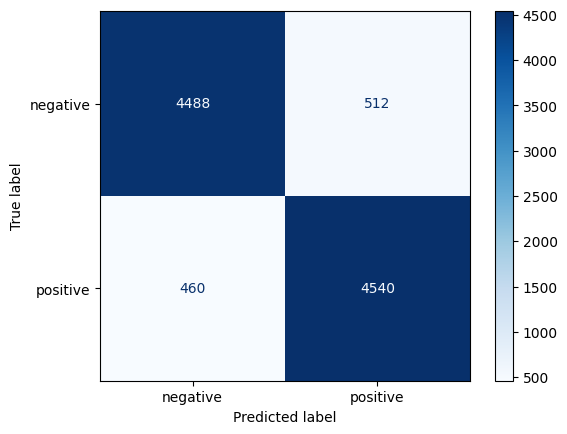

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# BoW evaluation
y_pred_bow = lr_bow.predict(X_test_BoW)

# Compute train and test accuracy
test_accuracy = accuracy_score(y_test, y_pred_bow)

# Print train and test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")
print("-" * 50)

# Classification report for BoW
print("\nBoW Classification Report:")
print(classification_report(y_test, y_pred_bow, target_names=["negative", "positive"]))
print(f"\n{'='*40}")

# Confusion matrix visualization
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_bow)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["negative", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Test Accuracy: 0.9056
--------------------------------------------------

TF-IDF Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000


Confusion Matrix:


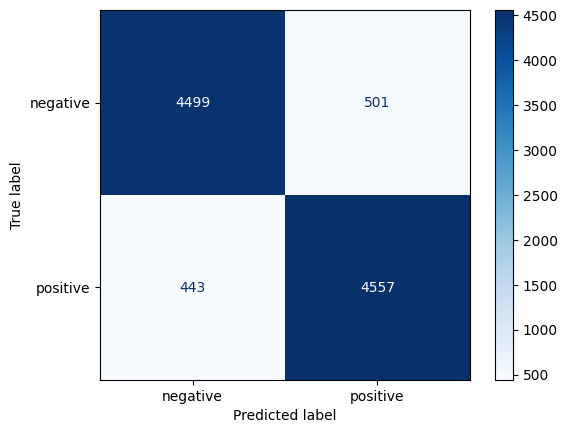

In [52]:
# TF-IDF evaluation
y_pred_vec = lr_tfidf.predict(X_test_vec)

# Compute train and test accuracy
test_accuracy = accuracy_score(y_test, y_pred_vec)

# Print train and test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")
print("-" * 50)

# Classification report for TF-IDF
print("\nTF-IDF Classification Report:")
print(classification_report(y_test, y_pred_vec, target_names=["negative", "positive"]))
print(f"\n{'='*40}")

# Confusion matrix visualization
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_vec)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["negative", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

The evaluation of the two versions of logistic regression — BoW and TF-IDF — shows similar performance across key metrics, including accuracy, precision, recall, and F1-score. All metrics achieve around 90% on the unseen dataset, demonstrating strong generalization ability.

### Analysing Mistakes Made in Prediction (False Positives and False Negatives)

In [63]:
results_df = pd.DataFrame({
    'text': X_test, # original raw review text
    'true_label': y_test,
    'predicted_label': y_pred_vec
})

# Decode numerical labels
label_map = {0: 'negative', 1: 'positive'}
results_df['true_label'] = results_df['true_label'].map(label_map)
results_df['predicted_label'] = results_df['predicted_label'].map(label_map)

# False Positives (predicted positive but actually negative)
false_positives = results_df[
    (results_df['predicted_label'] == 'positive') & 
    (results_df['true_label'] == 'negative')
]

print("\nFalse Positives:\n")
print(false_positives[['text', 'true_label', 'predicted_label']].head(10))


False Positives:

                                                  text true_label  \
59   something female lead perfect life always want...   negative   
81   mickey rourke hunt diane lane elmore leonard '...   negative   
98   check two octogenarian review leatherheads guy...   negative   
192  although enjoy bing crosby movie find movie pa...   negative   
199  watch truth love double entendre star like plu...   negative   
229  saw hallmark television movie originally air l...   negative   
278  message hero quite clear idea great china impo...   negative   
280  come get pakistan bash guy bollywood not make ...   negative   
288  take story dear people edinburgh 's heart true...   negative   
338  oddly enough fred macmurray play screwy part s...   negative   

    predicted_label  
59         positive  
81         positive  
98         positive  
192        positive  
199        positive  
229        positive  
278        positive  
280        positive  
288        positive  
3

In [64]:
# False Negatives (predicted positive but actually negative)
false_negatives = results_df[
    (results_df['predicted_label'] == 'negative') & 
    (results_df['true_label'] == 'positive')
]

print("\nFalse Negatives:\n")
print(false_negatives[['text', 'true_label', 'predicted_label']].head(10))


False Negatives:

                                                  text true_label  \
21   people need follow opinion herd mass critic ra...   positive   
36   r mood funand want relax enjoybade miyan chote...   positive   
52   ever since 1981 nintendo make great video game...   positive   
56   not bad film ever make actor not apalling scri...   positive   
63   hell rest night whilst walk desert travel heat...   positive   
68   consider movie one interesting funny movie tim...   positive   
110  film really eyeopening see film several time f...   positive   
113  yeah poster quite horrible piece worki think m...   positive   
133  curious rifle beckett use movie also caliber b...   positive   
151  spoiler simple movie simple people problem far...   positive   

    predicted_label  
21         negative  
36         negative  
52         negative  
56         negative  
63         negative  
68         negative  
110        negative  
113        negative  
133        negative  
1